In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load your feature-engineered data
df = pd.read_csv("../data/feature_engineered_data.csv", index_col=0)

# Drop non-numeric (just in case), and fill NA
df = df.select_dtypes(include='number').fillna(method='ffill')

# Scale the data
scaler = StandardScaler()
scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(scaled, columns=df.columns, index=df.index)

# Save it
df_scaled.to_csv("../data/scaled_data.csv")
print("scaled_data.csv created and saved.")


✅ scaled_data.csv created and saved.


In [31]:
import numpy as np

# Load scaled data
df_scaled = pd.read_csv("../data/feature_engineered_data.csv", index_col=0)
sequence_length = 30
sequences = []

# Slide window across the data
for i in range(len(df_scaled) - sequence_length):
    seq = df_scaled.iloc[i:i+sequence_length].values.flatten()
    sequences.append(seq)

df_seq = pd.DataFrame(sequences)

# Save it
df_seq.to_csv("../data/sequence_data.csv")
print("sequence_data.csv created and saved.")


sequence_data.csv created and saved.


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("You're using a device that's currently running on a:", device)


You're using a device that's currently running on a: cpu


In [6]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load top features
df = pd.read_csv('../data/top_features.csv', index_col=0)

# Define target (you can choose another target if needed)
target_column = df.columns[0]
X = df.drop(columns=[target_column])
y = df[target_column]

# Normalize features (Diffusion models benefit from scaled inputs)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

print(f"Training set shape: { X_train.shape }")
print(f"Test set shape: { X_test.shape }")


Training set shape: torch.Size([2920, 9])
Test set shape: torch.Size([730, 9])


In [8]:
import torch.nn as nn
import torch.nn.functional as F

# Simple denoiser MLP
class DenoiseMLP(nn.Module):
    def __init__(self, input_dim, time_embed_dim=64):
        super(DenoiseMLP, self).__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_embed_dim),
            nn.ReLU(),
            nn.Linear(time_embed_dim, input_dim)
        )
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x, t):
        t_embed = self.time_mlp(t)
        return self.model(x + t_embed)


# Beta schedule (linear noise increase)
def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

# Hyperparameters
timesteps = 1000
betas = linear_beta_schedule(timesteps)
alphas = 1. - betas
alpha_hats = torch.cumprod(alphas, dim=0)


In [11]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tqdm import tqdm

# Load features (we'll use autoencoder features for best performance)
df = pd.read_csv("../data/autoencoder_features.csv", index_col=0)
X = torch.tensor(df.values, dtype=torch.float32)

# Dataloader
batch_size = 128
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model
input_dim = X.shape[1]
model = DenoiseMLP(input_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 20


In [16]:
def sample_timesteps(n):
    return torch.randint(0, timesteps, (n,)).long()

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for batch in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}"):
        x = batch[0].to(device)
        t = sample_timesteps(x.shape[0]).to(device).unsqueeze(-1).float()

        # Add noise
        noise = torch.randn_like(x)
        sqrt_alpha_hat = alpha_hats[t.long()].sqrt().to(device)
        sqrt_one_minus_alpha_hat = (1 - alpha_hats[t.long()]).sqrt().to(device)
        x_t = sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * noise

        # Predict noise
        noise_pred = model(x_t, t / timesteps)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {epoch_loss / len(loader):.6f}")
print("Training complete!!! Model saved to 'models/diffusion_model.pth'")


Epoch 1/20: 100%|██████████| 29/29 [00:00<00:00, 180.84it/s]


Epoch 1 Loss: 0.243802


Epoch 2/20: 100%|██████████| 29/29 [00:00<00:00, 197.26it/s]


Epoch 2 Loss: 0.242565


Epoch 3/20: 100%|██████████| 29/29 [00:00<00:00, 134.04it/s]


Epoch 3 Loss: 0.246965


Epoch 4/20: 100%|██████████| 29/29 [00:00<00:00, 161.55it/s]


Epoch 4 Loss: 0.242777


Epoch 5/20: 100%|██████████| 29/29 [00:00<00:00, 176.45it/s]


Epoch 5 Loss: 0.238542


Epoch 6/20: 100%|██████████| 29/29 [00:00<00:00, 163.21it/s]


Epoch 6 Loss: 0.251629


Epoch 7/20: 100%|██████████| 29/29 [00:00<00:00, 184.73it/s]


Epoch 7 Loss: 0.247704


Epoch 8/20: 100%|██████████| 29/29 [00:00<00:00, 177.82it/s]


Epoch 8 Loss: 0.242841


Epoch 9/20: 100%|██████████| 29/29 [00:00<00:00, 206.85it/s]


Epoch 9 Loss: 0.242552


Epoch 10/20: 100%|██████████| 29/29 [00:00<00:00, 197.20it/s]


Epoch 10 Loss: 0.242469


Epoch 11/20: 100%|██████████| 29/29 [00:00<00:00, 127.06it/s]


Epoch 11 Loss: 0.248080


Epoch 12/20: 100%|██████████| 29/29 [00:00<00:00, 199.18it/s]


Epoch 12 Loss: 0.240595


Epoch 13/20: 100%|██████████| 29/29 [00:00<00:00, 221.21it/s]


Epoch 13 Loss: 0.247970


Epoch 14/20: 100%|██████████| 29/29 [00:00<00:00, 183.38it/s]


Epoch 14 Loss: 0.245170


Epoch 15/20: 100%|██████████| 29/29 [00:00<00:00, 184.97it/s]


Epoch 15 Loss: 0.242697


Epoch 16/20: 100%|██████████| 29/29 [00:00<00:00, 228.23it/s]


Epoch 16 Loss: 0.246369


Epoch 17/20: 100%|██████████| 29/29 [00:00<00:00, 183.17it/s]


Epoch 17 Loss: 0.241498


Epoch 18/20: 100%|██████████| 29/29 [00:00<00:00, 206.29it/s]


Epoch 18 Loss: 0.240302


Epoch 19/20: 100%|██████████| 29/29 [00:00<00:00, 193.21it/s]


Epoch 19 Loss: 0.247974


Epoch 20/20: 100%|██████████| 29/29 [00:00<00:00, 121.27it/s]

Epoch 20 Loss: 0.242953
Training complete!!! Model saved to 'models/diffusion_model.pth'


In [17]:
import torch.nn as nn

class DiffusionModel(nn.Module):
    def __init__(self, seq_length, n_features):
        super(DiffusionModel, self).__init__()
        self.seq_length = seq_length
        self.n_features = n_features

        self.net = nn.Sequential(
            nn.Linear(seq_length * n_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, seq_length * n_features)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        out = self.net(x)
        return out.view(batch_size, self.seq_length, self.n_features)


In [60]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

import torch
from diffusion_model import Simple1DDiffusionModel
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Set sequence parameters (same as training)
sequence_length = 30
df_seq = pd.read_csv("../data/feature_engineered_data.csv", index_col=0)
n_features = df_seq.shape[1]

# Load model
model = Simple1DDiffusionModel(seq_len=sequence_length)
model.load_state_dict(torch.load("../models/pm25_diffusion_model.pth"))
model.eval()


Simple1DDiffusionModel(
  (net): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=30, bias=True)
  )
)

In [6]:
import pandas as pd
import os

# Load the scaled data
df_scaled = pd.read_csv("../data/scaled_data.csv", index_col=0)

# Set the sequence length (should be 30 as used in training)
sequence_length = 30

# Create overlapping sequences
sequences = []
for i in range(len(df_scaled) - sequence_length):
    seq = df_scaled.iloc[i:i+sequence_length].values.flatten()
    sequences.append(seq)

# Create DataFrame of sequences
df_seq = pd.DataFrame(sequences)
df_seq.to_csv("../data/sequence_data.csv", index=False)

print("sequence_data.csv regenerated and saved.")


sequence_data.csv regenerated and saved.


Running DDPM Evaluation
Current Working Directory: c:\Users\ASus\air-quality-diffusion\notebooks
Files in '../data': ['autoencoder_features.csv', 'baseline_results.csv', 'city_day.csv', 'city_hour.csv', 'feature_engineered_data.csv', 'pca_features.csv', 'processed_city_data.csv', 'scaled_data.csv', 'sequence_data.csv', 'stations.csv', 'station_day.csv', 'station_hour.csv', 'top_features.csv', 'uncorrelated_features.csv']


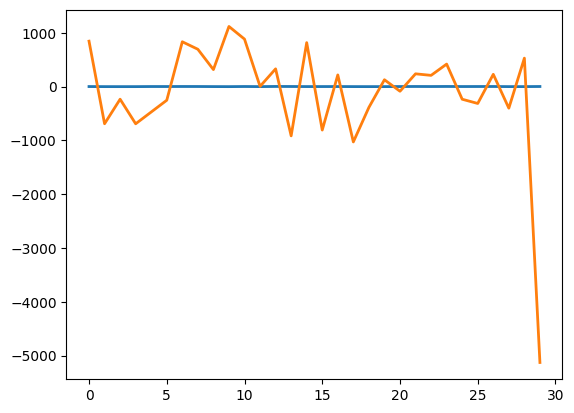

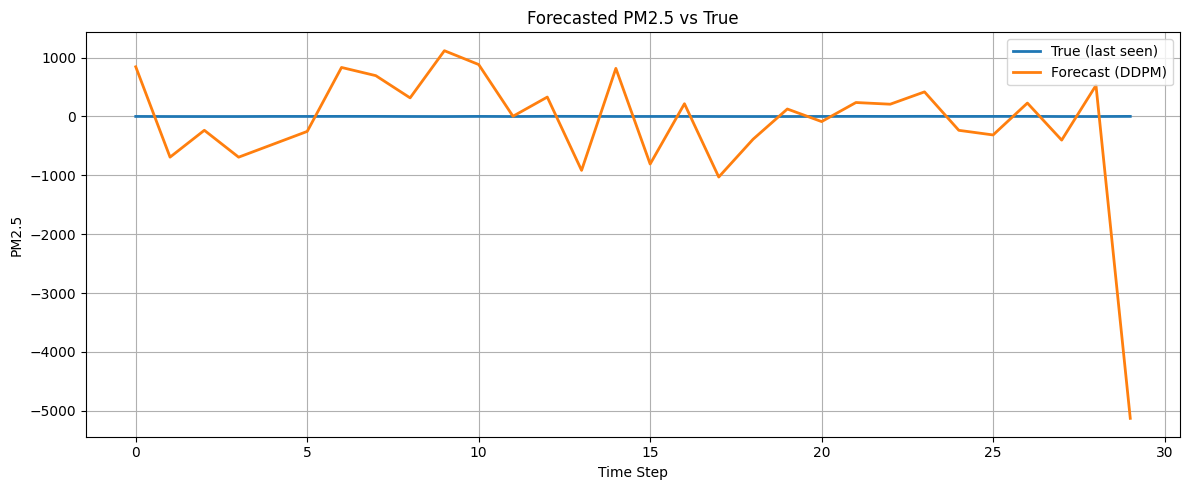

DDPM Forecast Evaluation : 
RMSE: 1096.8446
R²: -1273935.9416


In [34]:
import sys
import os
sys.path.append(os.path.abspath("../src"))

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from diffusion_model import Simple1DDiffusionModel

# Ensure the working directory is set correctly

print("Running DDPM Evaluation")
print("Current Working Directory:", os.getcwd())
print("Files in '../data':", os.listdir("../data"))

# Load the scaled data
df_scaled = pd.read_csv("../data/scaled_data.csv", index_col=0)
data = df_scaled.values
n_features = data.shape[1]

# Create model with proper seq_len
model = Simple1DDiffusionModel(seq_len=30)
model.load_state_dict(torch.load("../models/pm25_diffusion_model.pth"))
model.eval()

# Sampling function (flattened input/output)
@torch.no_grad()
def sample_forecast(model, steps, input_dim, alpha=0.1):
    x = torch.randn(1, input_dim)  # Start from noise
    for t in reversed(range(steps)):
        noise = model(x)
        x = x - alpha * noise  # Smaller, smoother update instead of x = x - noise / steps
    return x.squeeze().cpu().numpy()

# Forecast
forecast = sample_forecast(model, steps=100, input_dim=30, alpha=0.1)
forecast = forecast.reshape(sequence_length, 1)

true_seq = data[-sequence_length:]

plt.plot(true_seq[:, 0], label="True (last seen)", linewidth=2)
plt.plot(forecast[:, 0], label="Forecast (DDPM)", linewidth=2)
# Ground truth
true_seq = data[-sequence_length:]

# Plot PM2.5
plt.figure(figsize=(12, 5))
plt.plot(true_seq[:, 0], label="True (last seen)", linewidth=2)
plt.plot(forecast[:, 0], label="Forecast (DDPM)", linewidth=2)
plt.legend()
plt.title("Forecasted PM2.5 vs True")
plt.xlabel("Time Step")
plt.ylabel("PM2.5")
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation
rmse = np.sqrt(mean_squared_error(true_seq[:, 0], forecast[:, 0]))
r2 = r2_score(true_seq[:, 0], forecast[:, 0])

print("DDPM Forecast Evaluation : ")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


In [32]:
from sklearn.model_selection import train_test_split

# Load the same scaled data
df_scaled = pd.read_csv("../data/scaled_data.csv", index_col=0)
data = df_scaled.values

# Create sequences
def create_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len][0])  # Predict PM2.5 only
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(data, seq_len=30)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=False)


In [33]:
# Generate predictions for each test point using last observed 30 steps
ddpm_preds = []
true_pm25 = []

for i in range(len(X_test)):
    last_sequence = X_test[i]  # shape: (30, n_features)
    last_pm25_seq = last_sequence[:, 0]  # just PM2.5 input
    
    x = torch.tensor(last_pm25_seq, dtype=torch.float32).unsqueeze(0)  # (1, 30)
    for t in reversed(range(100)):
        noise = model(x)
        x = x - 0.1 * noise
    ddpm_preds.append(x.squeeze().detach().numpy()[0])
    true_pm25.append(y_test[i])

# Evaluate
ddpm_preds = np.array(ddpm_preds)
true_pm25 = np.array(true_pm25)
rmse = np.sqrt(mean_squared_error(true_pm25, ddpm_preds))
r2 = r2_score(true_pm25, ddpm_preds)

print("DDPM Forecast Evaluation (Fixed)")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


DDPM Forecast Evaluation (Fixed)
RMSE: 1096.3579
R²:   -1240420.0662
